# Array API example for LinearDiscriminantAnalysis

### This benchmark is ran on a Nvidia GTX 3090 and a AMD 5950x.

In [1]:
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

X_np, y_np = make_classification(random_state=0,
                                 n_samples=500_000, n_features=300)
X_np, y_np = X_np.astype(np.float32), y_np.astype(np.float32)
lda_np = LinearDiscriminantAnalysis()

In [2]:
from time import perf_counter
from functools import wraps


def timeit(f):
    @wraps(f)
    def wrap(*args, **kwargs):
        timing_results = []
        for _ in range(10):
            start = perf_counter()
            obj = f(*args, **kwargs)
            end = perf_counter()
            timing_results.append(end - start)
        return (obj, timing_results)
    return wrap

## Fit runtime for NumPy array

In [5]:
@timeit
def lda_np_fit():
    return lda_np.fit(X_np, y_np)

In [6]:
lda_np_fitted, lda_np_fit_results = lda_np_fit()

In [7]:
lda_np_fit_results

[10.516187733000152,
 10.517151113999716,
 10.492884919999597,
 10.54027571700044,
 10.29059758800031,
 10.465045095999812,
 10.496740431000035,
 10.476105129000644,
 10.603008382000553,
 10.50459001299987]

In [8]:
@timeit
def lda_np_predict():
    return lda_np_fitted.predict(X_np)

In [9]:
_, lda_np_predict_results = lda_np_predict()

In [10]:
lda_np_predict_results

[0.06625195600008738,
 0.05633547100023861,
 0.07885743699989689,
 0.051483326999914425,
 0.051505837999684445,
 0.07913585200003581,
 0.05169581200061657,
 0.051683900999705656,
 0.05149076699944999,
 0.05165315100020962]

## Runtime for PyTorch Tensor on CPU

In [3]:
import sklearn

# Enable ArrayAPI dispatching
sklearn.set_config(array_api_dispatch=True)

In [12]:
import torch

X_torch_cpu = torch.asarray(X_np)
y_torch_cpu = torch.asarray(y_np)

In [13]:
lda_torch_cpu = LinearDiscriminantAnalysis()

In [14]:
@timeit
def lda_torch_cpu_fit():
    return lda_torch_cpu.fit(X_torch_cpu, y_torch_cpu)

In [15]:
lda_torch_cpu_fitted, lda_torch_cpu_results = lda_torch_cpu_fit()

In [16]:
lda_torch_cpu_results

[2.1182146410001224,
 2.0594991859998117,
 2.06829082799959,
 2.0687498499992216,
 2.0757765140006086,
 2.068107881999822,
 2.060510852000334,
 2.078717444999711,
 2.078607035999994,
 2.086645089999365]

In [17]:
@timeit
def lda_torch_cpu_predict():
    return lda_torch_cpu_fitted.predict(X_torch_cpu)

In [18]:
_, lda_torch_cpu_predict_results = lda_torch_cpu_predict()

In [19]:
lda_torch_cpu_predict_results

[0.04787013199984358,
 0.044832488999418274,
 0.04440974899989669,
 0.044075063000491355,
 0.04418315399925632,
 0.04408434299966757,
 0.0439288999996279,
 0.043820107000101416,
 0.04397405100007745,
 0.04404068199983158]

## Runtime for PyTorch Tensor on CUDA

In [20]:
import torch

X_torch_cuda = torch.asarray(X_np, device="cuda")
y_torch_cuda = torch.asarray(y_np, device="cuda")

In [21]:
lda_torch_cuda = LinearDiscriminantAnalysis()

In [22]:
@timeit
def lda_torch_cuda_fit():
    estimator = lda_torch_cuda.fit(X_torch_cuda, y_torch_cuda)
    torch.cuda.synchronize(device="cuda")
    return estimator

In [92]:
lda_torch_cuda_fitted, lda_torch_cuda_fit_results = lda_torch_cuda_fit()

In [93]:
@timeit
def lda_torch_cuda_predict():
    results = lda_torch_cuda_fitted.predict(X_torch_cuda)
    torch.cuda.synchronize(device="cuda")
    return results

In [94]:
_, lda_torch_cuda_predict_results = lda_torch_cuda_predict()

## CuPy

In [6]:
import cupy

X_cupy = cupy.asarray(X_np)
y_cupy = cupy.asarray(y_np)

In [7]:
lda_cupy = LinearDiscriminantAnalysis()

In [10]:
@timeit
def lda_cupy_fit():
    output = lda_cupy.fit(X_cupy, y_cupy)
    cupy.cuda.stream.get_current_stream().synchronize()
    return output

In [11]:
lda_cupy_fitted, lda_cupy_fit_results = lda_cupy_fit()

In [13]:
lda_cupy_fit_results

[1.1028036239999892,
 0.9749162529999467,
 0.9745569199999977,
 0.9781964599999924,
 0.9788154940000027,
 0.9781140499999879,
 0.9780410449999977,
 0.9781301799999937,
 0.9780059139999935,
 0.9788264559999789]

In [16]:
@timeit
def lda_cupy_predict():
    output = lda_cupy_fitted.predict(X_cupy) 
    cupy.cuda.stream.get_current_stream().synchronize()
    return output

In [17]:
_, lda_cupy_predict_results = lda_cupy_predict()

In [18]:
lda_cupy_predict_results

[0.003597356000000218,
 0.003332068000020172,
 0.003292497999950683,
 0.003332806999992499,
 0.0032771080000202346,
 0.0033315880000373,
 0.0032843889999867315,
 0.003280116999974325,
 0.0032904880000046433,
 0.003273288999992019]

In [20]:
import pandas as pd
import seaborn as sns

In [26]:
results = pd.concat(
    [
        pd.DataFrame({"duration": lda_np_fit_results, "backend": "numpy", "method": "fit"}),
        pd.DataFrame({"duration": lda_np_predict_results, "backend": "numpy", "method": "predict"}),
        pd.DataFrame({"duration": lda_torch_cpu_results, "backend": "torch_cpu", "method": "fit"}),
        pd.DataFrame({"duration": lda_torch_cpu_predict_results, "backend": "torch_cpu", "method": "predict"}),
        pd.DataFrame({"duration": lda_torch_cuda_fit_results, "backend": "torch_cuda", "method": "fit"}),
        pd.DataFrame({"duration": lda_torch_cuda_predict_results, "backend": "torch_cuda", "method": "predict"}),
    ]
)

In [25]:
results.to_csv("results_backend.csv", index=False)

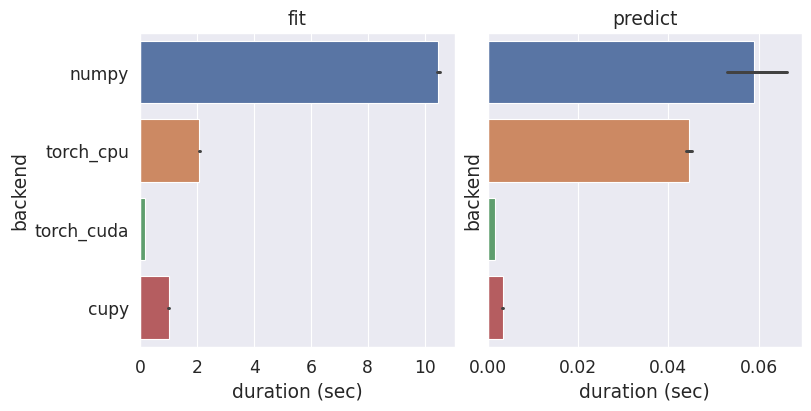

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

results = pd.read_csv("results_backend.csv")

sns.set_theme(context="paper", font_scale=1.4)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True, sharey=True)
sns.barplot(y="backend", x="duration", data=results[results["method"] == "fit"], ax=ax1)
ax1.set_xlabel("duration (sec)")
ax1.set_title("fit")

sns.barplot(y="backend", x="duration", data=results[results["method"] == "predict"], ax=ax2)
ax2.set_xlabel("duration (sec)")
ax2.set_title("predict")
fig.savefig("results_backend.png")

In [15]:
fig.savefig("results_backend.png")

## Check coefs are the same

In [13]:
import numpy as np

np_coef_ = np.asarray(lda_np.coef_)

# Is there a bettery way to convert cupy.array_api to a np.ndarray?
cu_coef_ = lda_torch_cuda.coef_.cpu().numpy()

np.testing.assert_allclose(np_coef_, cu_coef_, atol=1e-3)